In [119]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from statsmodels.graphics.tsaplots import plot_pacf

In [248]:
train = pd.read_csv('train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
test = pd.read_csv('test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)

In [249]:
train_test = pd.concat([train, test], ignore_index=True)

In [250]:
train_test

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [251]:
#change date datatype as datetime
train_test.date = pd.to_datetime(train_test.date)

train_test['year'] = train_test.date.dt.year
train_test['month'] = train_test.date.dt.month
train_test['dayofmonth'] = train_test.date.dt.day
train_test['dayofweek'] = train_test.date.dt.dayofweek
train_test['dayname'] = train_test.date.dt.strftime('%A')

In [252]:
oil = pd.read_csv('oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')

In [253]:
oil['avg_oil_7'] = oil['dcoilwtico'].rolling(7).mean()

In [254]:
oil

,dcoilwtico,avg_oil_7
date,,
2013-01-01,NaN,NaN
2013-01-02,93.14,NaN
2013-01-03,92.97,NaN
2013-01-04,93.12,NaN
2013-01-07,93.20,NaN
...,...,...
2017-08-25,47.65,47.720000
2017-08-28,46.40,47.624286
2017-08-29,46.46,47.320000


In [255]:
trends = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
trends = trends.join(oil, how='outer')
#to understand fillna https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
trends['avg_oil_7'].fillna(method = 'ffill', inplace = True)
trends.dropna(inplace = True)

In [256]:
trends

,dcoilwtico,avg_oil_7
2013-01-10,93.81,93.218571
2013-01-11,93.60,93.284286
2013-01-14,94.27,93.470000
2013-01-15,93.26,93.490000
2013-01-16,94.28,93.644286
...,...,...
2017-08-25,47.65,47.720000
2017-08-28,46.40,47.624286
2017-08-29,46.46,47.320000
2017-08-30,45.96,47.115714


C:\Users\tompe\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


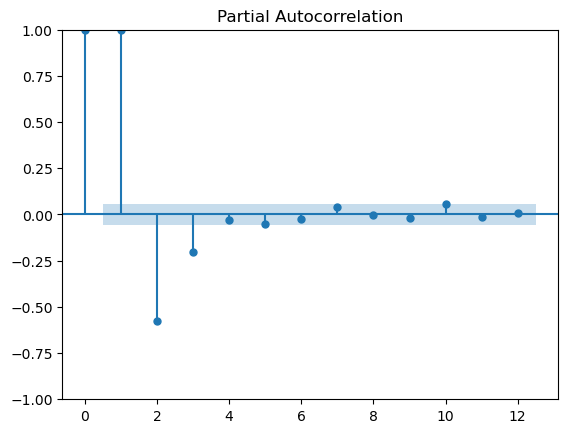

In [257]:
_ = plot_pacf(trends.avg_oil_7, lags = 12)

In [258]:
# Adding lages based on the auto correlation plot (up to 5 will be reasonable for the 7 day rolling average)
n_lags = 3
for l in range(1, n_lags+1):
    trends[f'oil_lags7_{l}'] = trends.avg_oil_7.shift(l)
trends.dropna(inplace = True)
trends.count()

dcoilwtico     1166
avg_oil_7      1166
oil_lags7_1    1166
oil_lags7_2    1166
oil_lags7_3    1166
dtype: int64

In [259]:
trends['date_str'] = trends.index.astype(str)
trends.drop('dcoilwtico', axis=1, inplace=True)

In [260]:
trends

,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3,date_str
2013-01-15,93.490000,93.470000,93.284286,93.218571,2013-01-15
2013-01-16,93.644286,93.490000,93.470000,93.284286,2013-01-16
2013-01-17,93.970000,93.644286,93.490000,93.470000,2013-01-17
2013-01-18,94.331429,93.970000,93.644286,93.490000,2013-01-18
2013-01-22,94.331429,94.331429,93.970000,93.644286,2013-01-22
...,...,...,...,...,...
2017-08-25,47.720000,47.598571,47.645714,47.522857,2017-08-25
2017-08-28,47.624286,47.720000,47.598571,47.645714,2017-08-28
2017-08-29,47.320000,47.624286,47.720000,47.598571,2017-08-29
2017-08-30,47.115714,47.320000,47.624286,47.720000,2017-08-30


In [261]:
#filling missing data
oil = oil.interpolate(method='linear')
#the first row is still missing the value
oil.iloc[0] = oil.iloc[1]

#some days are skipped. Filling up the gap.

start_date = train_test.date.min() 
# from beggining of the train date and the end of test date
number_of_days = 1704 #1703
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()
oil['date_str'] = oil.index.astype(str)

In [262]:
oil

,dcoilwtico,date_str
date,,
2013-01-01,93.140000,2013-01-01
2013-01-02,93.140000,2013-01-02
2013-01-03,92.970000,2013-01-03
2013-01-04,93.120000,2013-01-04
2013-01-05,93.146667,2013-01-05
...,...,...
2017-08-27,46.816667,2017-08-27
2017-08-28,46.400000,2017-08-28
2017-08-29,46.460000,2017-08-29


In [263]:
# add oil price to the train_test date
train_test['date_str'] = train_test.date.astype(str)
train_test = pd.merge(train_test,oil,how='left',on='date_str')

In [264]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,date_str,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,2013-01-01,93.14
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,2013-01-01,93.14
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,2013-01-01,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,2013-01-01,93.14
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,2013-01-01,93.14
...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,2017-08-31,47.26
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,2017-08-31,47.26
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,2017-08-31,47.26
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,2017-08-31,47.26


In [265]:
train_test = pd.merge(train_test,trends,how='left',on='date_str')
train_test.drop(columns='date_str',axis=1,inplace=True)

In [266]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286


In [267]:
train_test['onpromo_7'] = train_test['onpromotion'].rolling(7).mean()
train_test['onpromo_28'] = train_test['onpromotion'].rolling(28).mean()

In [268]:
train_test['onpromo_7'].fillna(0, inplace=True)
train_test['onpromo_28'].fillna(0, inplace=True)

In [269]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3,onpromo_7,onpromo_28
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN,0.000000,0.000000
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN,0.000000,0.000000
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286,5.142857,7.607143
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286,5.000000,7.607143
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286,5.142857,7.607143
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286,3.571429,6.928571


In [270]:
stores = pd.read_csv('stores.csv',index_col='store_nbr')
train_test = pd.merge(train_test,stores,how='left',on='store_nbr')

In [271]:
holiday = pd.read_csv('holidays_events.csv')
holiday.query('transferred==True')

# transferred day is not celebrated
holiday = holiday.query('transferred ==False')
holiday.description = holiday.description.str.replace('Traslado ','')

#national
national = holiday.query('locale=="National"')
day_off = national.query('type!="Work Day" or type!="Event"').set_index('date')['description'].to_dict()
train_test['date_str'] = train_test.date.astype(str)
train_test['national_holiday'] = [1 if a in day_off else 0 for a in train_test.date_str]

event = national.query('type=="Event"').set_index('date')['description'].to_dict()
train_test['national_event'] =[1 if a in event else 0 for a in train_test.date_str]

work_day = national.query('type=="Work Day"').set_index('date')['description'].to_dict()
train_test['national_workday'] = [1 if a in work_day else 0 for a in train_test.date_str]

#weekend
train_test['weekend'] = [1 if a>=5 else 0 for a in train_test.dayofweek]

In [272]:
#locale
#locale is corresponding to city of train_df
local = holiday.query('locale=="Local"')
local_dic = local.set_index('date').locale_name.to_dict()
train_test['local_holiday']=[1 if b in local_dic and local_dic[b]== a else 0 for a,b in zip(train_test.city,train_test.date_str)]

In [273]:
#Regional
#Regional is corresonding to state of train_df
regional = holiday.query('locale=="Regional"')
regional_dic = regional.set_index('date').locale_name.to_dict()
train_test['regional_holiday']= [1 if b in regional_dic and regional_dic[b]== a else 0 for a,b in zip(train_test.state,train_test.date_str)]

In [274]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,state,type,cluster,date_str,national_holiday,national_event,national_workday,weekend,local_holiday,regional_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0


In [275]:
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date','store_nbr','family']).sort_index()
train.head()

sales  onpromotion
date       store_nbr family                        
2013-01-01 1         AUTOMOTIVE    0.0            0
                     BABY CARE     0.0            0
                     BEAUTY        0.0            0
                     BEVERAGES     0.0            0
                     BOOKS         0.0            0

In [276]:
y_dp = train.unstack(['store_nbr', 'family'])
y_dp

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                 ... onpromotion        \
store_nbr                                        ...          54         
family     CELEBRATION CLEANING  DAIRY     DELI  ...   MAGAZINES MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...           0     0   
2013-01-02         0.0   1060.0  579.0  164.069  ...           0     0   
2013-01-03         0.0    836.0  453.0  151.582  ...           0     0   
2013-01-04         0.0    827.0  460.0  131.411  ...           0     0   
2013-01-05         0.0    811.0  464.0  118.613  ...           0     0   
...                ...      ...    ...      ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302  ...           0     0   
2017-08-12         3.0    351.0  526.0   99.488  ...           0     0   
2017-08-13         1.0    169.0  266.0   47.770  ...           0     0   
2017-08-14         4.0    571.0  699.0  154.578  ...           0     0   
2017-08-15        21.0    703.0  602.0  116.402  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01             0            0                       0       0   
2013-01-02             0            0                       0       0   
2013-01-03             0            0                       0       0   
2013-01-04             0            0                       0       0   
2013-01-05             0            0                       0       0   
...                  ...          ...                     ...     ...   
2017-08-11             6            0                       0      10   
2017-08-12             5            0                       0       0   
2017-08-13             6            0                       0       0   
2017-08-14             6            0                       0       0   
2017-08-15             5            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01              0       0                          0       0  
2013-01-02              0       0                          0       0  
2013-01-03              0       0                          0       0  
2013-01-04              0       0                          0       0  
2013-01-05              0       0                          0       0  
...                   ...     ...                        ...     ...  
2017-08-11              0       3

In [277]:
fourier = CalendarFourier(freq = 'M', order = 4)
dp = DeterministicProcess(index = y_dp.index, order = 1, 
                          seasonal = False, 
                          constant = False, 
                          additional_terms = [fourier], 
                          drop = True)
X_fourier = dp.in_sample()

In [278]:
X_fourier

,trend,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,
2013-01-01,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,2.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2013-01-03,3.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2013-01-04,4.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2013-01-05,5.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...
2017-08-11,1680.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1681.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1682.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


In [279]:
X_fourier_test = dp.out_of_sample(steps = 16)
X_fourier_test

,trend,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
2017-08-16,1685.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1686.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1687.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1688.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
2017-08-20,1689.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139
2017-08-21,1690.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347
2017-08-22,1691.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653
2017-08-23,1692.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964
2017-08-24,1693.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530
2017-08-25,1694.0,-0.988468,0.151428,-0.299363,-0.954139,0.897805,-0.440394,0.571268,0.820763


In [280]:
dp_week = pd.concat([X_fourier, X_fourier_test])
dp_week['date_str'] = dp_week.index.astype(str)

In [281]:
dp_week

,trend,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",date_str
2013-01-01,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2013-01-01
2013-01-02,2.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,2013-01-02
2013-01-03,3.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,2013-01-03
2013-01-04,4.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,2013-01-04
2013-01-05,5.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,2013-01-05
...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1696.0,-0.848644,0.528964,-0.897805,-0.440394,-0.101168,-0.994869,0.790776,-0.612106,2017-08-27
2017-08-28,1697.0,-0.724793,0.688967,-0.998717,-0.050649,-0.651372,-0.758758,0.101168,-0.994869,2017-08-28
2017-08-29,1698.0,-0.571268,0.820763,-0.937752,0.347305,-0.968077,-0.250653,-0.651372,-0.758758,2017-08-29
2017-08-30,1699.0,-0.394356,0.918958,-0.724793,0.688967,-0.937752,0.347305,-0.998717,-0.050649,2017-08-30


In [282]:
train_test = pd.merge(train_test,dp_week,how='left',on='date_str')

In [283]:
len(train_test.query('date_str=="2013-01-01"'))

1782

In [284]:
train_test.sales = np.log1p(train_test.sales)

In [285]:
train_test['Istest'] = False

#remove leap year day
#train_test = train_test.query('date_str !="2016-02-29"')

train_test['Lag_16'] = train_test['sales'].shift(1782*16)
train_test['Lag_17'] = train_test['sales'].shift(1782*17)
train_test['Lag_18'] = train_test['sales'].shift(1782*18)
train_test['Lag_19'] = train_test['sales'].shift(1782*19)
train_test['Lag_20'] = train_test['sales'].shift(1782*20)
train_test["Lag_21"] = train_test['sales'].shift(1782*21)
train_test['Lag_22'] = train_test['sales'].shift(1782*22)
train_test['Lag_28'] = train_test['sales'].shift(1782*28)
train_test['Lag_31'] = train_test['sales'].shift(1782*31)

train_test['Lag_365'] = train_test['sales'].shift(1782*365)

train_test = train_test.query('Istest==False')

An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly. Alpha, which ranges from 0 to 1, determines how important the current observation is in the calculation of the EWMA. Alpha represents the degree of weighting decrease and is a constant smoothing factor. A higher alpha discounts older data faster thereby placing greater relevance on your more current data.

From the correlation data it appears the lowest alphas and lowest lags have the highest correlations to sales. Which means the older data is still important as part of the EWM calculations. 

In [286]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            feature_name = 'sales_ewm_alpha_' + str(alpha).replace(".", "") + '_lag_' + str(lag)
            dataframe[feature_name] = dataframe.groupby(["store_nbr", "family"])['sales'].\
                transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    return dataframe

In [287]:
alphas = [0.95, 0.8, 0.65, 0.5]
lags =[1, 7,30]
train_test = ewm_features(train_test, alphas, lags)

In [288]:
corr = train_test.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.975231
sales_ewm_alpha_065_lag_1     0.973496
sales_ewm_alpha_08_lag_1      0.971192
sales_ewm_alpha_05_lag_7      0.971186
sales_ewm_alpha_065_lag_7     0.970779
sales_ewm_alpha_08_lag_7      0.969665
sales_ewm_alpha_095_lag_1     0.968111
sales_ewm_alpha_095_lag_7     0.967665
Lag_21                        0.947122
Lag_16                        0.941619
Lag_17                        0.939454
Lag_20                        0.939114
Lag_18                        0.938127
Lag_28                        0.937857
Lag_19                        0.937607
Lag_22                        0.935959
sales_ewm_alpha_05_lag_30     0.934552
sales_ewm_alpha_065_lag_30    0.931726
sales_ewm_alpha_08_lag_30     0.928695
sales_ewm_alpha_095_lag_30    0.925129
Lag_31                        0.922037
Lag_365                       0.850742
onpromotion                   0.329234
onpromo_7                     0.208629
trend                    

In [35]:
#train_test = pd.get_dummies(data=train_test,columns=['year', 'month', 'dayofmonth', 'dayofweek', 'store_nbr',
#                                                    'type', 'cluster'])

In [289]:
print(train_test.isna().sum())

date                               0
store_nbr                          0
family                             0
sales                          28512
onpromotion                        0
year                               0
month                              0
dayofmonth                         0
dayofweek                          0
dayname                            0
dcoilwtico                         0
avg_oil_7                     951588
oil_lags7_1                   951588
oil_lags7_2                   951588
oil_lags7_3                   951588
onpromo_7                          0
onpromo_28                         0
city                               0
state                              0
type                               0
cluster                            0
date_str                           0
national_holiday                   0
national_event                     0
national_workday                   0
weekend                            0
local_holiday                      0
r

In [290]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,6.338358,6.012643,6.012643,6.311631,5.977488,5.977488,6.283037,5.957384,5.957384,6.244803
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,3.953042,4.984993,4.984993,4.014010,4.938647,4.938647,4.105066,4.894600,4.894600,4.210488
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,7.788738,7.682595,7.682595,7.722496,7.606924,7.606924,7.659226,7.532320,7.532320,7.590557
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,5.253514,4.885929,4.885929,5.043656,4.941502,4.941502,4.787096,4.982981,4.982981,4.438414


In [291]:
lags = ['Lag_16','Lag_17','Lag_18','Lag_19','Lag_20','Lag_21','Lag_22','Lag_28','Lag_31','Lag_365',
       'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'avg_oil_7', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7',
        'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30',
        'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1',
        'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']

In [292]:
train_test[lags]=train_test[lags].fillna(0)

In [293]:
print(train_test.isna().sum())

date                              0
store_nbr                         0
family                            0
sales                         28512
onpromotion                       0
year                              0
month                             0
dayofmonth                        0
dayofweek                         0
dayname                           0
dcoilwtico                        0
avg_oil_7                         0
oil_lags7_1                       0
oil_lags7_2                       0
oil_lags7_3                       0
onpromo_7                         0
onpromo_28                        0
city                              0
state                             0
type                              0
cluster                           0
date_str                          0
national_holiday                  0
national_event                    0
national_workday                  0
weekend                           0
local_holiday                     0
regional_holiday            

In [294]:
print(train_test.columns.tolist())

['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month', 'dayofmonth', 'dayofweek', 'dayname', 'dcoilwtico', 'avg_oil_7', 'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'onpromo_7', 'onpromo_28', 'city', 'state', 'type', 'cluster', 'date_str', 'national_holiday', 'national_event', 'national_workday', 'weekend', 'local_holiday', 'regional_holiday', 'trend', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)', 'Istest', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22', 'Lag_28', 'Lag_31', 'Lag_365', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7', 'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30', 'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1', 'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']


In [295]:
FEATURES = train_test.columns.tolist()

no_features = ('date', 'family', 'sales', 'dayname', 'date_str', 'Istest')

for i in no_features:
    FEATURES.remove(i)

TARGET =['sales']

In [296]:
train_test.dtypes

date                          datetime64[ns]
store_nbr                              int64
family                                object
sales                                float64
onpromotion                            int64
year                                   int64
month                                  int64
dayofmonth                             int64
dayofweek                              int64
dayname                               object
dcoilwtico                           float64
avg_oil_7                            float64
oil_lags7_1                          float64
oil_lags7_2                          float64
oil_lags7_3                          float64
onpromo_7                            float64
onpromo_28                           float64
city                                  object
state                                 object
type                                  object
cluster                                int64
date_str                              object
national_h

In [297]:
categories = ['family','city','state', 'type']
for i in categories:
    encoder = preprocessing.LabelEncoder()
    train_test[i] = encoder.fit_transform(train_test[i])

In [298]:
print(train_test.isna().sum())

date                              0
store_nbr                         0
family                            0
sales                         28512
onpromotion                       0
year                              0
month                             0
dayofmonth                        0
dayofweek                         0
dayname                           0
dcoilwtico                        0
avg_oil_7                         0
oil_lags7_1                       0
oil_lags7_2                       0
oil_lags7_3                       0
onpromo_7                         0
onpromo_28                        0
city                              0
state                             0
type                              0
cluster                           0
date_str                          0
national_holiday                  0
national_event                    0
national_workday                  0
weekend                           0
local_holiday                     0
regional_holiday            

In [299]:
train = train_test[train_test['sales'].notnull()].copy()
test = train_test[train_test['sales'].isnull()].drop(['sales'],axis=1)

In [300]:
X_train,X_val,y_train,y_val = train_test_split(train,train[TARGET],test_size=0.05,shuffle=False)

In [301]:
linear = LinearRegression()
model = linear.fit(X_train[FEATURES],y_train)

predictions= model.predict(X_val[FEATURES])
predictions = [a if a>0 else 0 for a in predictions]
print('MSLE: ' + str(mean_squared_log_error(y_val,predictions)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_val, predictions)))

MSLE: 0.032482674005342334
RMSLE: 0.18022950370386734


C:\Users\tompe\anaconda3\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
C:\Users\tompe\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\tompe\anaconda3\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

In [105]:
xgb = XGBRegressor(n_estimators=500)
xgb.fit(X_train[FEATURES], y_train,
        eval_set=[(X_train[FEATURES],y_train),(X_val[FEATURES], y_val)],
       verbose=False,early_stopping_rounds=10)

#predictions have negative. Changed negative values to 0.
predictions= xgb.predict(X_val[FEATURES])
predictions = [a if a>0 else 0 for a in predictions]
print('MSLE: ',mean_squared_log_error(y_val,predictions))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_val,predictions)))

"xgb = XGBRegressor(n_estimators=500)\nxgb.fit(X_train[FEATURES], y_train,\n        eval_set=[(X_train[FEATURES],y_train),(X_val[FEATURES], y_val)],\n       verbose=False,early_stopping_rounds=10)\n\n#predictions have negative. Changed negative values to 0.\npredictions= xgb.predict(X_val[FEATURES])\npredictions = [a if a>0 else 0 for a in predictions]\nprint('MSLE: ',mean_squared_log_error(y_val,predictions))\nprint('RMSLE:', np.sqrt(mean_squared_log_error(y_val,predictions)))"

In [302]:
cat = CatBoostRegressor()
cat.fit(X_train[FEATURES], y_train,
        eval_set=[(X_train[FEATURES],y_train),(X_val[FEATURES], y_val)],
       verbose=False,early_stopping_rounds=10)

#predictions have negative. Changed negative values to 0.
cat_predictions= cat.predict(X_val[FEATURES])
cat_predictions = [a if a>0 else 0 for a in cat_predictions]
print('MSLE: ',mean_squared_log_error(y_val,cat_predictions))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_val, cat_predictions)))

MSLE:  0.028771460834604353
RMSLE: 0.16962152232132677


In [28]:
params = {'lambda': 6.105970537016599, 'alpha': 0.874716179324655, 'eta': 0.047228549789593455, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 155}

# Making a submission file

In [303]:
#xgb = XGBRegressor(**params)
#xgb = XGBRegressor(n_estimators=500)
#xgb.fit(train[FEATURES], train[TARGET],verbose=False)

#xgb_predictions= xgb.predict(test[FEATURES])
#xgb_predictions = [a if a>0 else 0 for a in xgb_predictions]

cat_predictions = cat.predict((test[FEATURES]))
cat_predictions = [a if a>0 else 0 for a in cat_predictions]

In [58]:
#predictions = [0.5* a + 0.5 * b for a,b in zip(xgb_predictions,cat_predictions)] 

In [304]:
output = pd.read_csv('sample_submission.csv',index_col='id')
output['sales']= np.expm1(cat_predictions)

In [305]:
output.to_csv('./submissions/submit-more-features.csv')

Kaggle baselines; using catboost 0.46628; using catboost and xgb with all features 0.44831; using catboost and xgb with mostly default features 0.45294.

With not removing the lag 365 values the Kaggle score with catboost only is 0.46764. Adding in the average oil and the 3 oil lags the catboost Kaggle score is 0.46911. Adding back in transactions creates catboost Kaggle score of 2.49923. Using the log of the transactions creates a catboost Kaggle score of 2.49923. Scaling transactions creates a catboost Kaggle score of 2.53831.

Adding 28 day moving average and 1 lag to oil creates a catboost Kaggle score of 0.47207. Adding 7 and 28 day rolling averages for onpromotions creates a catboost Kaggle score of 0.46367. Keeping the 7 and 28 day onpromotions rolling averages and getting rid of the 28 day and 1 lag to oil creates a catboost Kaggle score of 0.45694.

Adding in all the EWM values creates a catboost Kaggle score of 0.44528. Adding in a wide range of dummy values creates a catboost Kaggle score of 0.44706. Eliminating the wide range of dummy variables and then eliminating the variables with negative correlations to sales creates a catboost Kaggle score of 0.4574.

Adding in the monthly fourier variables creates a cataboost Kaggle score of 0.45965. Instead adding in monthly fourier variables creates a catboost Kaggle score of 0.46323.